In [1]:
from datasets import load_from_disk


In [3]:
dataset=load_from_disk('/shared/how2_all.dataset').with_format('torch')

In [32]:
dataset[392]['vid'].shape

torch.Size([2048])

In [45]:
# Train string encoders
en_data = [" ".join(x) for x in dataset['en']]
pt_data = [" ".join(x) for x in dataset['pt']]
sm_data = [" ".join(x) for x in dataset['sm'] if x]

In [59]:
#en_training_corpus = (
#    en_data[i : i + 1000]
#    for i in range(0, len(en_data), 1000)
#)

In [48]:
from transformers import AutoTokenizer

#old_tokenizer = AutoTokenizer.from_pretrained("gpt2")
#old_tokenizer.encode(" ".join(dataset[0]['sm']))

In [146]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
                    vocab_size=8192)

In [117]:
tokenizer.train_from_iterator(sm_data,trainer)

In [118]:
tokenizer.save('sm_tokenizer')

In [119]:
tokenizer.get_vocab_size()
tokenizer.get_vocab()

{'apped': 7302,
 'calves': 7902,
 'robe': 4426,
 'crystal': 4703,
 'fant': 5226,
 'fortune': 4575,
 'loveall': 5919,
 'birdcage': 6483,
 'beats': 2749,
 'spread': 4128,
 'bear': 1835,
 'testing': 4828,
 'suffering': 7187,
 'outdoorsman': 7229,
 'therap': 758,
 'mouse': 4207,
 'nicely': 7917,
 'carpenter': 4389,
 'feren': 3278,
 'exer': 245,
 'cir': 1033,
 'things': 2047,
 'mechan': 1241,
 'colepsy': 7348,
 'shelter': 7977,
 'angelo': 8171,
 'shine': 4412,
 'pod': 2066,
 'leading': 4344,
 'dynam': 5716,
 'apples': 6407,
 'orchid': 7346,
 'equine': 3059,
 'instructor': 258,
 'noseblunt': 7573,
 'cu': 462,
 'eliminate': 4377,
 'word': 1586,
 'ics': 604,
 'comers': 7845,
 'rate': 4108,
 'nurse': 4030,
 'sound': 1458,
 'swee': 6844,
 'intervie': 3008,
 'garlic': 2293,
 'planets': 7790,
 'stands': 6477,
 'scheduling': 3628,
 'bloo': 5217,
 'wondering': 7969,
 'antiques': 3730,
 'ank': 1342,
 'cy': 537,
 'peanut': 4727,
 'cages': 5944,
 'editor': 3481,
 'listening': 3779,
 'promin': 7864,
 'i

In [152]:
sm_tokenizer.encode(sm_data[23])
#sm_data

[67,
 2769,
 616,
 119,
 438,
 305,
 594,
 13,
 6248,
 12,
 727,
 58,
 73,
 5224,
 83,
 7120,
 99,
 119,
 1821,
 136,
 421,
 119,
 1117,
 14,
 1728,
 305,
 594,
 13,
 6248,
 202,
 342,
 186,
 5287,
 1187,
 9,
 48,
 5890,
 93,
 102,
 92,
 30,
 1371,
 3584,
 58,
 76,
 77,
 80,
 63,
 594,
 13,
 397,
 14]

In [150]:
from transformers import PreTrainedTokenizerFast
sm_tokenizer = PreTrainedTokenizerFast(tokenizer_file="sm_tokenizer")
en_tokenizer = PreTrainedTokenizerFast(tokenizer_file="en_tokenizer")
pt_tokenizer = PreTrainedTokenizerFast(tokenizer_file="pt_tokenizer")

In [155]:
import torch
def dataset_reorg(batch):
    data_dict = {
        'vid': {'indices': torch.arange(1,len(batch['vid'])+1),
                'values': batch['vid']},
        'aud': {'values': batch['aud']},
        'en': {'tokens': en_tokenizer.encode(" ".join(batch['en']))},
        'pt': {'tokens': pt_tokenizer.encode(" ".join(batch['pt']))},
        'sm': {'tokens': sm_tokenizer.encode(" ".join(batch['sm']) if batch['sm'] else "")}
    }
    return data_dict


In [271]:
def hotfix(batch):
    batch['vid']['indices'] = batch['vid']['indices'] + 1
    return(batch)

In [273]:
#dataset = dataset.map(dataset_reorg)
dataset = dataset.map(hotfix, num_proc=16)

Map (num_proc=16):   0%|          | 0/184949 [00:00<?, ? examples/s]

In [2]:
from datasets import load_from_disk
#dataset.save_to_disk('/shared/how2_all_proc')

In [3]:
dataset = load_from_disk('/shared/how2_all_proc')

In [4]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('.'))))

In [31]:
import encoders
from encoders import MultimodalCollator
import importlib

importlib.reload(encoders)
#importlib.reload(model)

<module 'encoders' from '/efs-private/multimodal/encoders.py'>

In [32]:
modality_config = {'aud':{'type':'matrix','pad_len':2048, 'max_channels':40},
                   'en':{'type':'sequence','pad_len':256, 'data_col_name':"tokens"},
                   'pt':{'type':'sequence','pad_len':256, 'data_col_name':"tokens"},
                   'sm':{'type':'sequence','pad_len':128, 'data_col_name':"tokens"},
                   'vid':{'type':'sequence','pad_len':2048},
                  }

In [33]:
mc = MultimodalCollator(modality_config)

In [34]:
mc.modality_collators.keys()
#sample = dataset[0]
#sample.pop('name',None)
#sample.keys()

dict_keys(['aud', 'en', 'pt', 'sm', 'vid'])

In [12]:
sample = dataset[10:18]
sample.pop('name',None)

['--8pSDeC-fg_1',
 '--8pSDeC-fg_10',
 '--8pSDeC-fg_11',
 '--8pSDeC-fg_12',
 '--8pSDeC-fg_13',
 '--8pSDeC-fg_14',
 '--8pSDeC-fg_15',
 '--8pSDeC-fg_16']

In [35]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
                        dataset, shuffle=True, collate_fn=mc,
                        batch_size=8,
                        prefetch_factor=4, num_workers=2
                )
dl_iter = iter(train_dataloader)

In [ ]:
collator = BioZorroCollator(pad_len=config.pad_len, pad_token=0, attn_mask=True)

In [26]:
#for a in train_dataloader:
#    sample=a
    #for k,v in a.items():
    #    print(f"{k}:{v.shape}")
    #exit()

In [39]:
for i in range(5):
    sample = next(dl_iter)
    for k,v in sample.items():
        for v2 in v.values():
            print(f"{k}:{v2.shape}")

aud:torch.Size([8, 2048, 40])
en:torch.Size([8, 256])
en:torch.Size([8, 256])
pt:torch.Size([8, 256])
pt:torch.Size([8, 256])
sm:torch.Size([8, 128])
sm:torch.Size([8, 128])
vid:torch.Size([8, 2048])
vid:torch.Size([8, 2048])
vid:torch.Size([8, 2048])
aud:torch.Size([8, 2048, 40])
en:torch.Size([8, 256])
en:torch.Size([8, 256])
pt:torch.Size([8, 256])
pt:torch.Size([8, 256])
sm:torch.Size([8, 128])
sm:torch.Size([8, 128])
vid:torch.Size([8, 2048])
vid:torch.Size([8, 2048])
vid:torch.Size([8, 2048])
aud:torch.Size([8, 2048, 40])
en:torch.Size([8, 256])
en:torch.Size([8, 256])
pt:torch.Size([8, 256])
pt:torch.Size([8, 256])
sm:torch.Size([8, 128])
sm:torch.Size([8, 128])
vid:torch.Size([8, 2048])
vid:torch.Size([8, 2048])
vid:torch.Size([8, 2048])
aud:torch.Size([8, 2048, 40])
en:torch.Size([8, 256])
en:torch.Size([8, 256])
pt:torch.Size([8, 256])
pt:torch.Size([8, 256])
sm:torch.Size([8, 128])
sm:torch.Size([8, 128])
vid:torch.Size([8, 2048])
vid:torch.Size([8, 2048])
vid:torch.Size([8,

In [37]:
sample

{'aud': {'values': tensor([[[ 1.0293e+01,  1.4074e+01,  1.5368e+01,  ...,  1.4706e+01,
             1.4404e+01,  1.3697e+01],
           [ 1.2080e+01,  1.4280e+01,  1.6147e+01,  ...,  1.4706e+01,
             1.4404e+01,  1.3389e+01],
           [ 1.1578e+01,  1.3397e+01,  1.6225e+01,  ...,  1.5894e+01,
             1.5503e+01,  1.4995e+01],
           ...,
           [-1.0000e+04, -1.0000e+04, -1.0000e+04,  ..., -1.0000e+04,
            -1.0000e+04, -1.0000e+04],
           [-1.0000e+04, -1.0000e+04, -1.0000e+04,  ..., -1.0000e+04,
            -1.0000e+04, -1.0000e+04],
           [-1.0000e+04, -1.0000e+04, -1.0000e+04,  ..., -1.0000e+04,
            -1.0000e+04, -1.0000e+04]],
  
          [[ 1.1876e+01,  1.4209e+01,  1.7955e+01,  ...,  1.8331e+01,
             1.9452e+01,  1.8965e+01],
           [ 1.3558e+01,  1.5207e+01,  1.9663e+01,  ...,  1.8095e+01,
             2.0407e+01,  2.0452e+01],
           [ 1.3151e+01,  1.5642e+01,  2.0220e+01,  ...,  1.8656e+01,
             1.9929e+

In [38]:
from encoders import PatchEncoder

In [17]:
penc=PatchEncoder(max_tokens=320, patch_size = (32,8))

In [18]:
x,at = penc(collated['aud'])

In [19]:
collated['aud']['values'][6,:,:]

tensor([[    14.1159,     16.2858,     15.9622,  ...,     13.2830,
             13.0229,     12.6879],
        [    14.3077,     16.7415,     16.5961,  ...,     13.9218,
             12.8430,     12.2267],
        [    15.1387,     17.2530,     17.0790,  ...,     13.9710,
             13.5673,     12.5957],
        ...,
        [-10000.0000, -10000.0000, -10000.0000,  ..., -10000.0000,
         -10000.0000, -10000.0000],
        [-10000.0000, -10000.0000, -10000.0000,  ..., -10000.0000,
         -10000.0000, -10000.0000],
        [-10000.0000, -10000.0000, -10000.0000,  ..., -10000.0000,
         -10000.0000, -10000.0000]])

In [20]:
batch['aud']['values'][3].shape

NameError: name 'batch' is not defined

In [532]:
collated['aud']['values'].shape

torch.Size([8, 2048, 40])

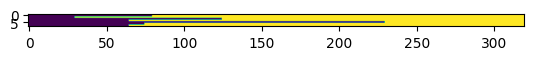

In [533]:
import matplotlib.pyplot as plt
plt.imshow(at)

In [16]:
encoder_configs = {'aud':{'type':'PatchEncoder',
                         'max_tokens':320, 
                         'patch_size':(32,8)},
                   'en':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'pt':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'sm':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'vid':{'type':'TabularEncoder',
                          "num_embeddings":2048,
                          'max_tokens':2048,
                         },
                  }

In [17]:
from encoders import encoders_dict
encoder_classes = {modality_name: encoders_dict[encoder_config['type']](**encoder_config)
                         for modality_name, encoder_config in encoder_configs.items()}

In [26]:
#encoder_classes = None

In [18]:
token_types = list(collated.keys())
tokens, attention_masks = zip(*[encoder_classes[modality_name](collated[modality_name])
                   for modality_name in token_types])

{'tokens': tensor([[ 936,  646,  118,  ...,    0,    0,    0],
        [2787,  113,  553,  ...,    0,    0,    0],
        [ 366,  144,  113,  ...,    0,    0,    0],
        ...,
        [3020,  434,  159,  ...,    0,    0,    0],
        [ 284,   11,   83,  ...,    0,    0,    0],
        [ 330,  118, 2625,  ...,    0,    0,    0]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}
{'tokens': tensor([[1350,  771,  119,  ...,    0,    0,    0],
        [ 261,  227,  561,  ...,    0,    0,    0],
        [ 381,  360,  156,  ...,    0,    0,    0],
        ...,
        [1759,  472,  177,  ...,    0,    0,    0],
        [ 107,  316,  557,  ...,    0,    0,    0],
        [ 643,  119,   80,  ...,    0,    0,    0]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
 

In [28]:
tokens

(tensor([[[-0.8065, -0.7556,  1.8182,  ...,  0.5336,  0.1504, -0.0399],
          [-0.6251, -0.6853,  1.7297,  ...,  0.4453,  0.1072,  0.0351],
          [-1.3333,  0.0306,  1.6114,  ...,  1.3236, -0.1118, -0.2603],
          ...,
          [-1.2580, -0.3370,  1.8117,  ...,  0.9178,  0.1335, -0.2491],
          [-1.3704, -0.1506,  1.9158,  ...,  1.0557,  0.0300, -0.2704],
          [-1.4346, -0.0863,  1.7615,  ...,  1.1182, -0.0207, -0.2369]],
 
         [[-0.8065, -0.7556,  1.8182,  ...,  0.5336,  0.1504, -0.0399],
          [-0.6251, -0.6853,  1.7297,  ...,  0.4453,  0.1072,  0.0351],
          [-1.3333,  0.0306,  1.6114,  ...,  1.3236, -0.1118, -0.2603],
          ...,
          [-1.2580, -0.3370,  1.8117,  ...,  0.9178,  0.1335, -0.2491],
          [-1.3704, -0.1506,  1.9158,  ...,  1.0557,  0.0300, -0.2704],
          [-1.4346, -0.0863,  1.7615,  ...,  1.1182, -0.0207, -0.2369]],
 
         [[-0.8065, -0.7556,  1.8182,  ...,  0.5336,  0.1504, -0.0399],
          [-0.6251, -0.6853,

In [579]:
tokens[0].shape

torch.Size([8, 2048, 512])

In [19]:
#from encoders import MultimodalCollator
import model
from model import MFDOOM
import importlib
importlib.reload(model)
importlib.reload(encoders)

<module 'encoders' from '/efs-private/multimodal/encoders.py'>

In [598]:
from torchmultimodal.modules.losses.contrastive_loss_with_temperature import ContrastiveLossWithTemperature

In [596]:
torchmultimodal.__package__

'torchmultimodal'

In [20]:
doom = MFDOOM(encoder_configs, 512,4, device="cpu")

{frozenset({'en', 'aud'}): ContrastiveLossWithTemperature(), frozenset({'pt', 'aud'}): ContrastiveLossWithTemperature(), frozenset({'sm', 'aud'}): ContrastiveLossWithTemperature(), frozenset({'vid', 'aud'}): ContrastiveLossWithTemperature(), frozenset({'en', 'pt'}): ContrastiveLossWithTemperature(), frozenset({'en', 'sm'}): ContrastiveLossWithTemperature(), frozenset({'en', 'vid'}): ContrastiveLossWithTemperature(), frozenset({'sm', 'pt'}): ContrastiveLossWithTemperature(), frozenset({'vid', 'pt'}): ContrastiveLossWithTemperature(), frozenset({'vid', 'sm'}): ContrastiveLossWithTemperature()}
Token dims without fusions: 3136
torch.Size([3152])
torch.Size([3152, 3152])


In [21]:
doom(collated)

{'tokens': tensor([[ 936,  646,  118,  ...,    0,    0,    0],
        [2787,  113,  553,  ...,    0,    0,    0],
        [ 366,  144,  113,  ...,    0,    0,    0],
        ...,
        [3020,  434,  159,  ...,    0,    0,    0],
        [ 284,   11,   83,  ...,    0,    0,    0],
        [ 330,  118, 2625,  ...,    0,    0,    0]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}
{'tokens': tensor([[1350,  771,  119,  ...,    0,    0,    0],
        [ 261,  227,  561,  ...,    0,    0,    0],
        [ 381,  360,  156,  ...,    0,    0,    0],
        ...,
        [1759,  472,  177,  ...,    0,    0,    0],
        [ 107,  316,  557,  ...,    0,    0,    0],
        [ 643,  119,   80,  ...,    0,    0,    0]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
 

RuntimeError: The size of tensor a (3152) must match the size of tensor b (3024) at non-singleton dimension 3

In [23]:
2048+256+256+128+320+16

3024